In [1]:
## Step 0 - Parameters and Libraries

import DrainMethod
import sys
import os

## General parameters 

input_dir = os.path.join(os.getcwd(), "logs") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
#logName = 'Ciena_error_lines_20220701-20220715.txt' # Name of file to be parsed
#logName = 'ciena-mini.txt' # Name of file to be parsed
logName = 'Andriod_2k.log' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution

In [2]:
## Step 1 - Log Parsing Using Drain

## Drain parameters

st = 0.5 # Drain similarity threshold
depth = 5 # Max depth of the parsing tree

## Code

print('\n=== Starting Drain Parsing ===')
indir = os.path.join(input_dir, os.path.dirname(logName))
print(indir)
log_file = os.path.basename(logName)

parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
parser.parse(log_file)

parsedresult=os.path.join(output_dir, log_file + '_structured.csv')   


=== Starting Drain Parsing ===
c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\CSL\CSL-1\logs\
Parsing file: c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\CSL\CSL-1\logs\Andriod_2k.log


Parsing Progress: 100%|██████████| 2000/2000 [00:00<00:00, 13357.12it/s]


Parsing done. [Time taken: 0:00:00.561082]


In [3]:
## Step 2 - Embedding Creation Using Transformers

from sentence_transformers import SentenceTransformer
from pathlib import Path
import pandas as pd
import regex as re
import contextlib
import pickle

## General Parameters

vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
indir = os.path.join(input_dir, os.path.dirname(logName)) # Input directory

## Code

# Function to generate regular expression to split log messages
def generate_logformat_regex(log_format):
    headers = []
    splitters = re.split(r'(<[^<>]+>)', log_format)
    regex = ''
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(' +', '\\\s+', splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip('<').strip('>')
            regex += f'(?P<{header}>.*?)'
            headers.append(header)
    regex = re.compile('^' + regex + '$')
    return headers, regex

# Function to transform log file to dataframe 
def log_to_dataframe(log_file, regex, headers, logformat):
    log_messages = []
    linecount = 0
    with open(log_file, 'r') as fin:
        for line in fin.readlines():
            with contextlib.suppress(Exception):
                match = regex.search(line.strip())
                message = [match.group(header) for header in headers]
                log_messages.append(message)
                linecount += 1
    logdf = pd.DataFrame(log_messages, columns=headers)
    logdf.insert(0, 'LineId', None)
    logdf['LineId'] = [i + 1 for i in range(linecount)]
    return logdf

# Preprocesses dataframe with regexes, if necessary - more preprocessing to add
def preprocess_df(df_log):
    for idx, content in df_log["Content"].items():
        for currentRex in regex:
            df_log.at[idx,'Content'] = re.sub(currentRex, '<*>', content)
    return df_log

# Calls conversion from data to dataframe
def load_data():
    headers, regex = generate_logformat_regex(log_format)
    return log_to_dataframe(os.path.join(indir, logName), regex, headers, log_format)

# Transforms the dataset, creating raw vector file
def transform_dataset(raw_content):
    
    path_to_file = os.path.join(vector_dir, logName + '_vectors.vec')
    path = Path(path_to_file)
    vectors = []

    if (path.is_file()):
        vectors = pickle.load(open(path_to_file, 'rb'))
    else:
        # Using standard MPNet transformer
        model = SentenceTransformer('all-mpnet-base-v2')
        print("Iniciando encode")
        vectors = model.encode(raw_content)
        pickle.dump(vectors, open(path_to_file, 'wb'))
    
    return vectors

# Creates embeddings for log file
def transform(logName):
    print('Transforming file: ' + os.path.join(input_dir, logName))
    log_df = load_data()
    log_df = preprocess_df(log_df)
    return transform_dataset(log_df["Content"])

vector_mat = transform(os.path.basename(logName))


Transforming file: c:\Users\vbert\OneDrive\DOUTORADO Poly Mtl\Projeto\CSL\CSL-1\logs\Andriod_2k.log


In [4]:
print(type(vector_mat))
print("O número de linhas do arquivo transformado é {}".format(len(vector_mat)))
print("O número de colunas do arquivo transformado é {}".format(len(vector_mat[0])))
print(vector_mat[2][1])
print(vector_mat[0][0])

<class 'numpy.ndarray'>
O número de linhas do arquivo transformado é 2000
O número de colunas do arquivo transformado é 768
-0.04948146
-0.0075010364


In [5]:
## Step 3 - Creates matrix of parsed items

from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
import pandas as pd 

## General Parameters

output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

## Code

# Reads parameters list
full_df = pd.read_csv(output_csv)
var_df = full_df["ParameterList"]

# Breaks the string into lists
for i, line in var_df.items():
    var_df.at[i] = literal_eval(var_df.at[i])

# Transforms variables list to variable matrix
mlb = MultiLabelBinarizer()
var_df = pd.DataFrame(mlb.fit_transform(var_df),columns=mlb.classes_)
print ("A matrix parseada de variaveis tem o formato {}".format(var_df.shape))

A matrix parseada de variaveis tem o formato (2000, 1839)


In [6]:
## Step 4 - Concatenates Embeddings Matrix with Variables Matrix Using Numpy

import numpy as np

var_mat = var_df.to_numpy()

print("A matrix de vetores tem {} linhas".format(len(vector_mat)))
print("A matrix de vetores tem {} colunas".format(len(vector_mat[0])))
print("A matrix de variaveis tem {} linhas".format(len(var_mat)))
print("A matrix de variaveis tem {} colunas".format(len(var_mat[0])))

concat_mat = np.hstack((vector_mat,var_mat))

print("A matrix concatenada tem {} linhas".format(len(concat_mat)))
print("A matrix concatenada tem {} colunas".format(len(concat_mat[0])))

#np.savetxt("concat_mat_numpy.csv", concat_mat, delimiter=";")


A matrix de vetores tem 2000 linhas
A matrix de vetores tem 768 colunas
A matrix de variaveis tem 2000 linhas
A matrix de variaveis tem 1839 colunas
A matrix concatenada tem 2000 linhas
A matrix concatenada tem 2607 colunas


In [7]:
## Alternate Step 4 - Concatenates Embeddings Matrix with Variables Matrix Using Pandas

vector_df = pd.DataFrame(vector_mat, columns = None)

print("A matrix de vetores tem formato {}".format(vector_df.shape))
print("A matrix de variaveis tem formato {}".format(var_df.shape))

concat_df = pd.concat([vector_df, var_df], axis=1)

print("A matrix de variaveis tem formato {}".format(concat_df.shape))

#concat_mat.to_csv("concat_mat_pandas.csv")

A matrix de vetores tem formato (2000, 768)
A matrix de variaveis tem formato (2000, 1839)
A matrix de variaveis tem formato (2000, 2607)


In [10]:
## Step 5 - Clustering with K-Means

import hdbscan

from sklearn.cluster import KMeans

## Clusteriza com K-Means
num_clusters = 10
clusterer = KMeans(n_clusters=num_clusters)
concat_df.columns = concat_df.columns.astype(str)
clusterer.fit(concat_df)

cluster_num = clusterer.labels_.max()
print ("O numero de clusters e {}".format(cluster_num))
cluster_labels = clusterer.labels_
print ("Os clusters de cada elemento sao {}".format(cluster_labels))

c:\Users\vbert\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


O numero de clusters e 9
Os clusters de cada elemento sao [3 3 3 ... 6 6 6]


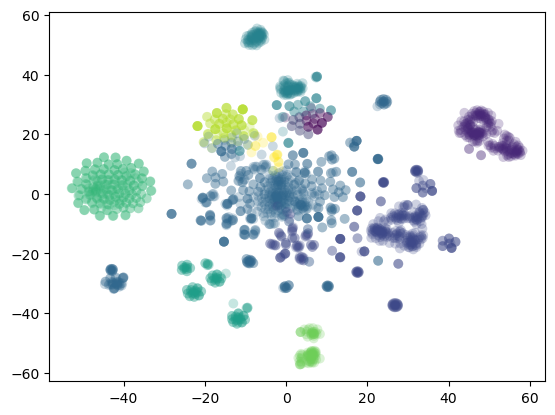

In [14]:
## Step 6 - Plotting with TSNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

concat_df.columns = concat_df.columns.astype(str)
projection = TSNE().fit_transform(concat_df)
#plt.scatter(*projection.T, **plot_kwds)

color_palette = sns.color_palette('Paired', cluster_num+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
#cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                         zip(cluster_colors, clusterer.probabilities_)]
cluster_member_colors = clusterer.labels_.astype(float)
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [15]:
## Step 7 - Checks number of outliers

cont = 0

for elem in clusterer.labels_:
   if (elem == -1):
      cont += 1

print("O número de outliers é {}".format(cont))
print("O número de total de elementos é {}".format(len(clusterer.labels_)))

O número de outliers é 0
O número de total de elementos é 2000


In [16]:
## Step 8 - Normalizes Embeddings

from sklearn.preprocessing import MinMaxScaler

# Normaliza entre 0 e 0.5
scaler = MinMaxScaler((0,0.75))

# Normaliza df de embeddings
vector_df = pd.DataFrame(vector_mat, columns = None)
vector_scaling = scaler.fit_transform(vector_df)
vector_df = pd.DataFrame(vector_scaling, columns = None)

# Concatena com o df de variaveis
concat_df = pd.concat([vector_df, var_df], axis=1)

c:\Users\vbert\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


O numero de clusters e 9
Os clusters de cada elemento sao [5 3 3 ... 2 2 2]


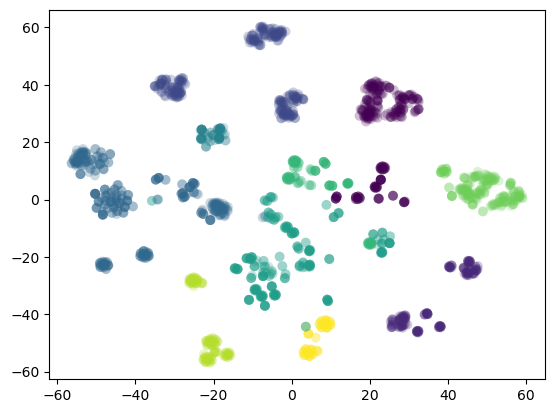

In [17]:
## Step 9 - Plots again, after normalization 

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

## Clusteriza com K-Means
num_clusters = 10
clusterer = KMeans(n_clusters=num_clusters)
concat_df.columns = concat_df.columns.astype(str)
clusterer.fit(concat_df)

cluster_num = clusterer.labels_.max()
print ("O numero de clusters e {}".format(cluster_num))
cluster_labels = clusterer.labels_
print ("Os clusters de cada elemento sao {}".format(cluster_labels))

concat_df.columns = concat_df.columns.astype(str)
projection = TSNE().fit_transform(concat_df)
#plt.scatter(*projection.T, **plot_kwds)

color_palette = sns.color_palette('Paired', cluster_num+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
#cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                         zip(cluster_colors, clusterer.probabilities_)]
cluster_member_colors = clusterer.labels_.astype(float)
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [18]:
## Step 10 - Checks number of outliers again

cont = 0

for elem in clusterer.labels_:
   if (elem == -1):
      cont += 1

print("O número de outliers é {}".format(cont))
print("O número de total de elementos é {}".format(len(clusterer.labels_)))

O número de outliers é 0
O número de total de elementos é 2000


In [20]:
## Step 11 - Creates a list of lists representing the clusters

import numpy as np

## General Parameters

cluster_idxs = []
cluster_lines = []
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

## Code

# Reads parameters list
full_df = pd.read_csv(output_csv)
elem_df = full_df["Content"]

# Creates blank lists
for elem in range (clusterer.labels_.max()+1):
    cluster_idxs.append([])
    cluster_lines.append([])

# Populate the lists with cluster elements
for idx, elem in np.ndenumerate(clusterer.labels_):
  if elem != -1:
    cluster_idxs[elem].append(idx[0])
    cluster_lines[elem].append(elem_df[idx[0]])

# Check sizes of each cluster
#for i in range(len(cluster_idxs)):
#   print(len(cluster_idxs[i]))

#print(cluster_lines[10][9])



In [21]:
## Step 12 - Eliminates stopwords on each cluster

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import gensim
import nltk

# Parameters
#nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Converts sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Removes stopwords from each sentence
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# Finds topics of a given cluster
def find_topics(cluster_list, cluster_number, num_topics):
    # Converts to words
    data_words = list(sent_to_words(cluster_list[cluster_number]))
    # Removes stop words - OPTIONAL
    #data_words = remove_stopwords(data_words)
    # Creates dictionary
    id2word = corpora.Dictionary(data_words)
    # Creates corpora
    corpus = [id2word.doc2bow(text) for text in data_words]
    # Builds LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
    # Prints topics
    pprint(lda_model.print_topics())
    pprint(lda_model.get_topic_terms(0))
    return lda_model

topics = find_topics(cluster_lines, 5, 1)

# Gets word topics
x = topics.show_topics(num_topics=1, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Prints only the topics
for topic,words in topics_words:
    print(words)

for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))

#Below Code Prints Only Words 
for topic,words in topics_words:
    print (" ".join(words))

[(0,
  '0.080*"com" + 0.073*"android" + 0.044*"server" + 0.041*"wm" + '
  '0.036*"intent" + 0.031*"activitymanager" + 0.030*"false" + 0.020*"tencent" '
  '+ 0.020*"windowmanager" + 0.016*"cmp"')]
[(5, 0.07998177),
 (42, 0.07320353),
 (54, 0.043831795),
 (61, 0.041346397),
 (204, 0.036149982),
 (108, 0.030727481),
 (8, 0.029597502),
 (14, 0.020334417),
 (16, 0.019656444),
 (171, 0.015815517)]
['com', 'android', 'server', 'wm', 'intent', 'activitymanager', 'false', 'tencent', 'windowmanager', 'cmp']
0::['com', 'android', 'server', 'wm', 'intent', 'activitymanager', 'false', 'tencent', 'windowmanager', 'cmp']
com android server wm intent activitymanager false tencent windowmanager cmp


In [24]:
## Step 13 - Finds most similar line inside the cluster to the words of the topic

from nltk.tokenize import WhitespaceTokenizer

tk = WhitespaceTokenizer()

def find_similar_lines(cluster_list, cluster_number, word_list):
    closest_line = 0
    similar_tokens = 0
    max_similarity = 0
    for idx, line in enumerate(cluster_list[cluster_number]):
        tokenized_line = tk.tokenize(line.lower())
        for token in tokenized_line:
            if token in word_list:
                similar_tokens += 1
        print ("A linha {} tem {} tokens iguais".format(idx, similar_tokens))
        if similar_tokens > max_similarity:
           max_similarity = similar_tokens
           closest_line = idx
        similar_tokens = 0
    print("A linha mais próxima é a {}, com {} tokens iguais ao tópico".format(closest_line, max_similarity))    
    return closest_line, max_similarity          

find_similar_lines(cluster_lines, 5, words)

A linha 0 tem 1 tokens iguais
A linha 1 tem 0 tokens iguais
A linha 2 tem 0 tokens iguais
A linha 3 tem 1 tokens iguais
A linha 4 tem 0 tokens iguais
A linha 5 tem 1 tokens iguais
A linha 6 tem 0 tokens iguais
A linha 7 tem 1 tokens iguais
A linha 8 tem 0 tokens iguais
A linha 9 tem 1 tokens iguais
A linha 10 tem 0 tokens iguais
A linha 11 tem 1 tokens iguais
A linha 12 tem 0 tokens iguais
A linha 13 tem 0 tokens iguais
A linha 14 tem 0 tokens iguais
A linha 15 tem 0 tokens iguais
A linha 16 tem 0 tokens iguais
A linha 17 tem 0 tokens iguais
A linha 18 tem 0 tokens iguais
A linha 19 tem 0 tokens iguais
A linha 20 tem 0 tokens iguais
A linha 21 tem 0 tokens iguais
A linha 22 tem 1 tokens iguais
A linha 23 tem 0 tokens iguais
A linha 24 tem 2 tokens iguais
A linha 25 tem 0 tokens iguais
A linha 26 tem 0 tokens iguais
A linha 27 tem 0 tokens iguais
A linha 28 tem 0 tokens iguais
A linha 29 tem 0 tokens iguais
A linha 30 tem 0 tokens iguais
A linha 31 tem 0 tokens iguais
A linha 32 tem 0 t

(24, 2)

In [23]:
for line in cluster_lines[5]:
    print(line)

03-17 16:13:38.811  1702  2395 D WindowManager: printFreezingDisplayLogsopening app wtoken = AppWindowToken{9f4ef63 token=Token{a64f992 ActivityRecord{de9231d u0 com.tencent.qt.qtl/.activity.info.NewsDetailXmlActivity t761}}}, allDrawn= false, startingDisplayed =  false, startingMoved =  false, isRelaunching =  false
03-17 16:13:38.839  1702  2113 V WindowManager: Skipping AppWindowToken{df0798e token=Token{78af589 ActivityRecord{3b04890 u0 com.tencent.qt.qtl/com.tencent.video.player.activity.PlayerActivity t761}}} -- going to hide
03-17 16:13:38.859  2227  2227 D TextView: visible is system.time.showampm
03-17 16:13:38.861  2227  2227 D TextView: mVisiblity.getValue is false
03-17 16:13:38.869  2227  2227 D TextView: visible is system.charge.show
03-17 16:13:38.871  2227  2227 D TextView: mVisiblity.getValue is false
03-17 16:13:38.875  2227  2227 D TextView: visible is system.call.count gt 0
03-17 16:13:38.877  2227  2227 D TextView: mVisiblity.getValue is false
03-17 16:13:38.881  2